# ==================================================
# S1 (Direct Strategy)
# M1 (LGBM)
# Standard Code _ Version 1.0 / KISLAB @ Kookmin University
# ==================================================

# Basic Options (for Extended Experiment)

In [9]:
# 기본 설정값
SMCODE = "S1M1"    # S1(Direct Strategy) + M2(MLP) 를 위한 Standard Code
PDCODE = "ONI"     # 품종코드
MDCODE = "LGBM"     # 모델코드
PDNAME = "Onion"   # 품종명(영문)
VARS = 2           # 확장변수 사용여부 (1: 가격만 사용, 2: 거래량 추가사용)

# 학습 기본변수 설정
PARAMS = {'num_leaves': 555,
  'min_child_weight': 0.034,
  'feature_fraction': 0.379,
  'bagging_fraction': 0.418,
  'min_data_in_leaf': 106,
  'objective': 'regression',
  'max_depth': -1,
  'learning_rate': 0.005,
  "boosting_type": "gbdt",
  "bagging_seed": 11,
  "metric": 'rmse',
  "verbose": -1,
  'reg_alpha': 0.3899,
  'reg_lambda': 0.648,
  'random_state': 222,
 }
ITER = 2500       # LGBM의 학습 반복 횟수

# Special Option 설정
FRAC = 1    # 검증기간 데이터 중 학습 데이터에 추가로 포함시킬 데이터의 비중 (0~1)
IRANGE = 365   # 가격 데이터를 입력으로 사용할 때 최대 총 며칠치 데이터를 사용할 것인지에 대한 옵션
SPLIT = 210    # 이 값을 0으로 설정할 경우, validation 수행하지 않음
WINSOR = 10   # 이상치 제거를 위한 Winsorizing 기준 설정 (단위: 퍼센트 / 이 값이 0일 경우, 이상치 제거 안함)

#BASEDATE = '2021-01-01'   # 검증용 데이터의 시작 시점 (D1을 위한 설정)
#USEDATE = '2021-12-31'    # 전체 사용할 데이터의 마지막 시점 (D1을 위한 설정)
BASEDATE = '2022-01-01'   # 검증용 데이터의 시작 시점 (D2를 위한 설정)
USEDATE = '2022-07-29'    # 전체 사용할 데이터의 마지막 시점 (D2를 위한 설정)

SELECTED = [30, 90, 180, 270, 365]    # 예측모델을 개발할 선택 시점
NSEL = len(SELECTED)    # 예측모델을 개발할 선택 시점의 총 갯수


# ============= 데이터셋 로드 ================  

# Ignore the warnings
import warnings
#warnings.filterwarnings('always')
warnings.filterwarnings('ignore')
import pandas as pd

#load data
raw = pd.read_excel('(140103-220728)양파(양파(일반)).xlsx', usecols=['일자', '품종', '거래량(톤)', '도매가격(원/kg)'])
# raw = raw[raw['품종']=='양파(일반)']

#create 'datetime' column
if '일자' in raw.columns:
    raw['일자'] = pd.to_datetime(raw['일자'])
    raw['DateTime'] = pd.to_datetime(raw['일자'])

#set datetime to index 
if raw.index.dtype == 'int64':
    raw.set_index('DateTime',inplace=True)

raw.drop (['품종', '일자'], axis=1, inplace=True)
raw.columns = ['Price', 'Volume']
for i in range(0, raw.shape[0]):
    raw['Volume'][i] = raw['Volume'][i].replace(',','')
raw['Volume'] = raw['Volume'].astype('float32')

#fill missing date & values
raw.asfreq('D')[raw.asfreq('D').isnull().sum(axis=1) > 0]
raw = raw.asfreq('D', method='ffill')


# Load Library

In [2]:
# System related and data input controls
import os

# Data manipulation, visualization and useful functions
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_rows = 50
pd.options.display.max_columns = 40
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Modeling algorithms
# General(Statistics/Econometrics)
from sklearn import preprocessing
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

# Regression
from lightgbm import LGBMRegressor as lgb
import lightgbm as lgb

# Evaluation metrics for regression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import joblib
import tensorflow as tf

In [3]:
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import load_model
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD, Nadam
import keras

# Feature Engineering code

In [4]:
### Feature engineering of all
def feature_engineering(raw):
    if 'datetime' in raw.columns:
        raw['datetime'] = pd.to_datetime(raw['datetime'])
        raw['DateTime'] = pd.to_datetime(raw['datetime'])

    if raw.index.dtype == 'int64':
        raw.set_index('DateTime', inplace=True)

    raw = raw.asfreq('D', method='ffill')
    raw['Price'].fillna(method='ffill',inplace=True)

    result = sm.tsa.seasonal_decompose(raw['Price'], model='additive')
    Y_trend = pd.DataFrame(result.trend)
    Y_trend.fillna(method='ffill', inplace=True)
    Y_trend.fillna(method='bfill', inplace=True)
    Y_trend.columns = ['Price_trend']
    Y_seasonal = pd.DataFrame(result.seasonal)
    Y_seasonal.fillna(method='ffill', inplace=True)
    Y_seasonal.fillna(method='bfill', inplace=True)
    Y_seasonal.columns = ['Price_seasonal']
    pd.concat([raw, Y_trend, Y_seasonal], axis=1).isnull().sum()
    if 'Price_trend' not in raw.columns:
        if 'Price_seasonal' not in raw.columns:
            raw = pd.concat([raw, Y_trend, Y_seasonal], axis=1)


    # STL분해 중 잔차 구하기
    result = sm.tsa.seasonal_decompose(raw['Price'], model='additive',period=30,two_sided=False)
    Y_remainder = pd.DataFrame(result.resid)
    Y_remainder.fillna(method='ffill', inplace=True)
    Y_remainder.fillna(method='bfill', inplace=True)
    Y_remainder.columns = ['Price_resid']
    raw = pd.concat([raw, Y_remainder], axis=1)
    
    #시간 변수 만들기
    raw['year'] = pd.DatetimeIndex(raw.index).year
    raw['month'] = pd.DatetimeIndex(raw.index).month
    raw['day'] = pd.DatetimeIndex(raw.index).day
    raw['day_of_year'] = pd.DatetimeIndex(raw.index).dayofyear
    raw['week_of_year'] = pd.DatetimeIndex(raw.index).weekofyear
    raw['season'] = raw.month%12 // 3 + 1
    raw['Quarter'] = (raw.index.quarter)
    raw['Quarter_ver2'] =(raw['Quarter'] + (raw.year - raw.year.min()) * 4)
    if 'Quarter' in raw.columns:
        if 'Quarter_Dummy' not in ['_'.join(col.split('_')[:2]) for col in raw.columns]:
            raw = pd.concat([raw, pd.get_dummies(raw['Quarter'], 
                                                 prefix='Quarter_Dummy', drop_first=True)], axis=1)
            del raw['Quarter']
    month_in_year = 12
    raw['month_sin'] = np.sin(2*np.pi*raw.month/month_in_year)
    raw['month_cos'] = np.cos(2*np.pi*raw.month/month_in_year)
    
    days_in_month = 30
    raw['day_sin'] = np.sin(2*np.pi*raw.day/days_in_month)
    raw['day_cos'] = np.cos(2*np.pi*raw.day/days_in_month)
    
    days_in_year = 365
    raw['day_of_year_sin'] = np.sin(2*np.pi*raw.day_of_year/days_in_year)
    raw['day_of_year_cos'] = np.cos(2*np.pi*raw.day_of_year/days_in_year)
    
    weeks_in_year = 52.1429
    raw['week_of_year_sin'] = np.sin(2*np.pi*raw.week_of_year/weeks_in_year)
    raw['week_of_year_cos'] = np.cos(2*np.pi*raw.week_of_year/weeks_in_year)
    
    seasons_in_year = 4
    raw['season_sin'] = np.sin(2*np.pi*raw.season/seasons_in_year)
    raw['season_cos'] = np.cos(2*np.pi*raw.season/seasons_in_year)
    raw.drop(['day', 'day_of_year', 'week_of_year', 'season'],axis=1,inplace=True)
    
    #가격 관련 변수 추가
    raw['rolling_mean_t30'] = raw['Price'].transform(lambda x: x.ewm(span=30,min_periods=1,adjust=True,ignore_na=False).mean())
    raw['rolling_mean_t90'] = raw['Price'].transform(lambda x: x.ewm(span=90,min_periods=1,adjust=True,ignore_na=False).mean())
    raw['rolling_mean_t180'] = raw['Price'].transform(lambda x: x.ewm(span=180,min_periods=1,adjust=True,ignore_na=False).mean())
    raw['rolling_mean_t270'] = raw['Price'].transform(lambda x: x.ewm(span=270,min_periods=1,adjust=True,ignore_na=False).mean())
    raw['rolling_mean_t365'] = raw['Price'].transform(lambda x: x.ewm(span=365,min_periods=1,adjust=True,ignore_na=False).mean())
    
    #for a in range(1,366):
    #    raw[f'Price_lag{a}'] = raw['Price'].shift(a)
    #    raw[f'Price_lag{a}'].fillna(0,inplace=True)
    
    raw['P_diff']=raw['Price'].diff(1)
    raw['P_diff'].fillna(0,inplace=True)
    raw['Year_a_go'] = raw['Price'].shift(365)
    raw['Y_diff'] = raw['Price']-raw['Year_a_go']
    raw['P_sum'] = raw['Price']+raw['P_diff']

    raw['month'] =(raw['month'] + (raw.year - raw.year.min()) * 12)
    mapd = raw.groupby('month')['Price'].mean()
    mapd = pd.DataFrame(mapd,index=mapd.index)  
    mapd.reset_index(drop=False,inplace=True)
    mapd.columns=['month','Mapd']
    raw = pd.merge(raw,mapd,how='left',left_on='month',right_on='month')
    raw['R_p'] = raw['Price']-raw['Mapd']
    
    raw.drop(['Mapd'],axis=1,inplace=True)
    
    return raw

# Data Partitioning

In [5]:
# Raw dataset selection
raw=raw[raw.index <= USEDATE]

# Train,Test split
test=raw[raw.index >= BASEDATE]
train=raw[raw.index < BASEDATE]
raw_idx = raw.index
train_idx = train.index

# LGBM with FE

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

Onion / LGBM+FE / Model30 Training Result



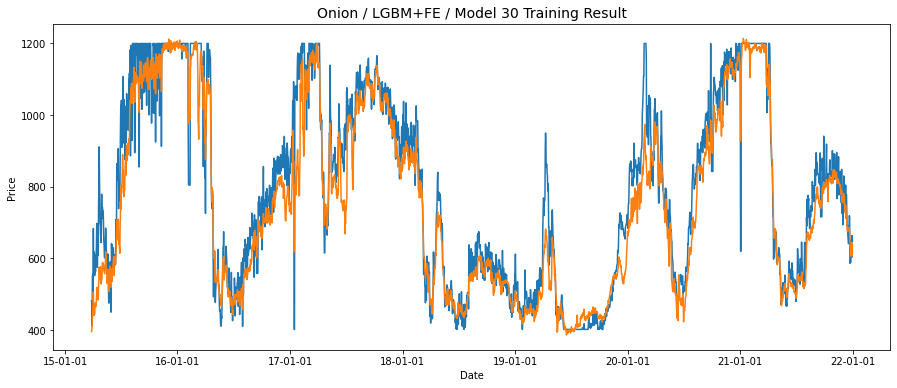

 20%|████████████████▊                                                                   | 1/5 [00:10<00:42, 10.68s/it]

Onion / LGBM+FE / Model90 Training Result



<Figure size 432x288 with 0 Axes>

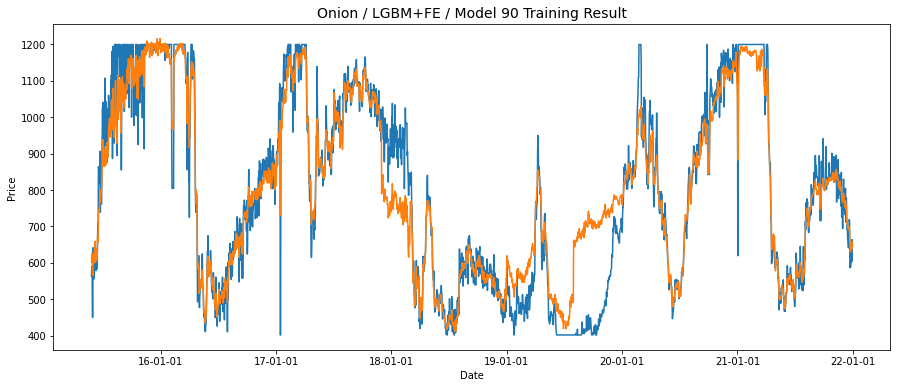

 40%|█████████████████████████████████▌                                                  | 2/5 [00:21<00:32, 10.75s/it]

Onion / LGBM+FE / Model180 Training Result



<Figure size 432x288 with 0 Axes>

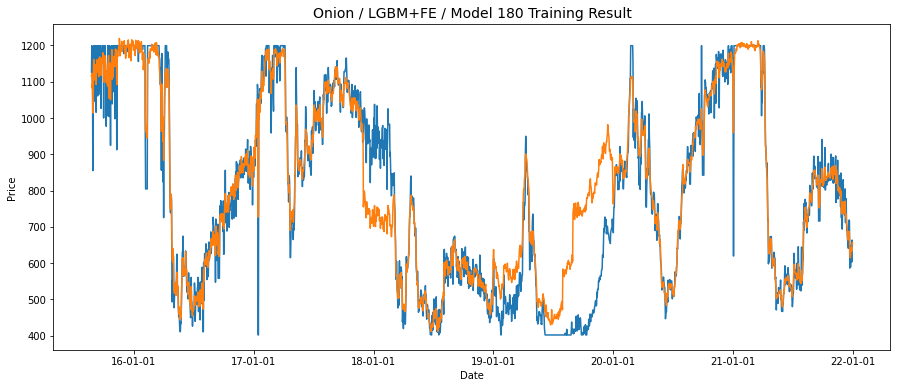

 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:31<00:21, 10.64s/it]

Onion / LGBM+FE / Model270 Training Result



<Figure size 432x288 with 0 Axes>

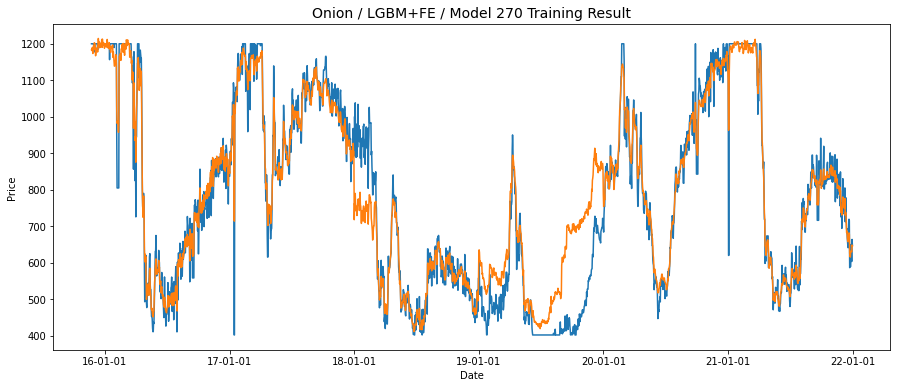

 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:42<00:10, 10.51s/it]

Onion / LGBM+FE / Model365 Training Result



<Figure size 432x288 with 0 Axes>

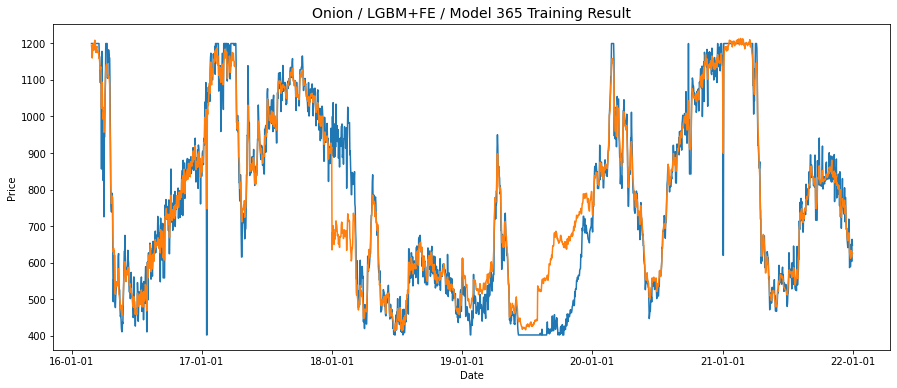

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:52<00:00, 10.46s/it]


<Figure size 432x288 with 0 Axes>

In [11]:
pred=[]

with tf.device("/device:CPU:0"):
    
    for day_num in tqdm(SELECTED):
        
        train_all = []
        train_all = raw.iloc[:,:1]

        
        # Price에 Outlier Treatment 적용 ---------------------#

        winsor_list = []
        winsor_list.append(WINSOR)
        winsor_list.append(100 - WINSOR)

        winsors = np.percentile(train_all['Price'][train_all.index < BASEDATE], winsor_list)
        winsor_min = winsors[0]
        winsor_max = winsors[1]

        train_all['Price'][train_all.index < BASEDATE] = np.where(train_all['Price'][train_all.index < BASEDATE] < winsor_min, winsor_min, train_all['Price'][train_all.index < BASEDATE])
        train_all['Price'][train_all.index < BASEDATE] = np.where(train_all['Price'][train_all.index < BASEDATE] > winsor_max, winsor_max, train_all['Price'][train_all.index < BASEDATE])

        #-----------------------------------------------------#
        
        V = pd.DataFrame(columns=['V'],index=raw.index)
        for i in range(day_num, IRANGE + day_num):
            train_all[f'Price_{i}lag'] = train_all['Price'].shift(i)
        
        raw_all = train_all.iloc[day_num:]
        raw_seed = raw_all.iloc[:,1:2]
        raw_seed.columns=['Price']
        raw_seed = feature_engineering(raw_seed)
        seed = raw_seed.iloc[:,1:]
        seed.index = raw_idx[day_num:]
        
        if VARS == 2:  # 거래량을 사용할 경우에만 처리
            V['Volume'] = raw['Volume'].shift(day_num)
            V['Volume'].iloc[day_num:]
            raw_final = pd.concat([raw_all,seed,V['Volume']],axis=1)
        else:
            raw_final = raw_all
        
        raw_final = raw_final.dropna(axis=0)  # NaN 결측치가 있는 경우, 학습대상에서 제외

        train_old = raw_final[raw_final.index < BASEDATE]
        test_new = raw_final[raw_final.index >= BASEDATE]

        
        # 검증기간 데이터 FRAC 추가  ---------------------#
        
        train_new = train_old.append(test_new.sample(frac=FRAC))
        
        y_train_raw = train_new['Price']
        x_train_raw = train_new.drop(['Price'],axis=1)        

        #-----------------------------------------------------#
        
        
        # Min-Max Normalization 적용
        scaler_X_tr = preprocessing.MinMaxScaler(feature_range=(0,1))
        X_train = scaler_X_tr.fit_transform(x_train_raw)

        
        
        # Validation 데이터을 학습에 사용할 경우에 대한 처리        
        
        if SPLIT == 0:
            x_train = X_train
            y_train = y_train_raw            
        else:
            x_train = X_train[:-SPLIT]
            y_train = y_train_raw[:-SPLIT]
            x_valid = X_train[-SPLIT:]
            y_valid = y_train_raw[-SPLIT:]
            
            dvalid = lgb.Dataset(x_valid, label=y_valid)

            
        # LGBM Training

        dtrain = lgb.Dataset(x_train, label=y_train)
                
        if SPLIT == 0:
            model = lgb.train(PARAMS, dtrain, num_boost_round=ITER)
        else:
            model = lgb.train(PARAMS, dtrain, num_boost_round=ITER, valid_sets=dvalid, verbose_eval=False)

        # Save model
        joblib.dump(model,f'{PDCODE}_{SMCODE}V{VARS}_{MDCODE}wFE_{day_num}.pkl')    

        
        # 학습한 결과의 예측모델 출력  ---------------------#
        
        y_train_real = train_old['Price']
        x_train_pred = scaler_X_tr.fit_transform(train_old.drop(['Price'],axis=1)) 
        y_train_pred = model.predict(x_train_pred)        
        
        print(f'{PDNAME} / {MDCODE}+FE / Model{day_num} Training Result\n')

        plot_data = pd.concat([pd.DataFrame(y_train_real.values, columns=['actual']), pd.DataFrame(y_train_pred, columns=['pred'])], axis=1)
        date_label = pd.date_range(start=train_old.index[0], end=train_old.index[-1], freq='D')

        fig, ax = plt.subplots(figsize=(15,6))

        ax.plot(date_label, plot_data)

        plt.title(PDNAME + ' / ' + MDCODE + '+FE / Model ' + str(day_num) + ' Training Result', fontsize=14)
        plt.xlabel('Date', fontsize=10)
        plt.ylabel('Price', fontsize=10)

        dateFmt = mdates.DateFormatter('%y-%m-%d')
        ax.xaxis.set_major_formatter(dateFmt)

        plt.show()
        plt.clf()        
        
        #-----------------------------------------------------#
        
        x_test = test_new.iloc[:,1:]
        y_test = test_new['Price']
        X_test= scaler_X_tr.transform(x_test)
        y_test_pred = model.predict(X_test)
        
        pred.append(y_test_pred)

# LGBM with FE / Visualization

Model30 Results



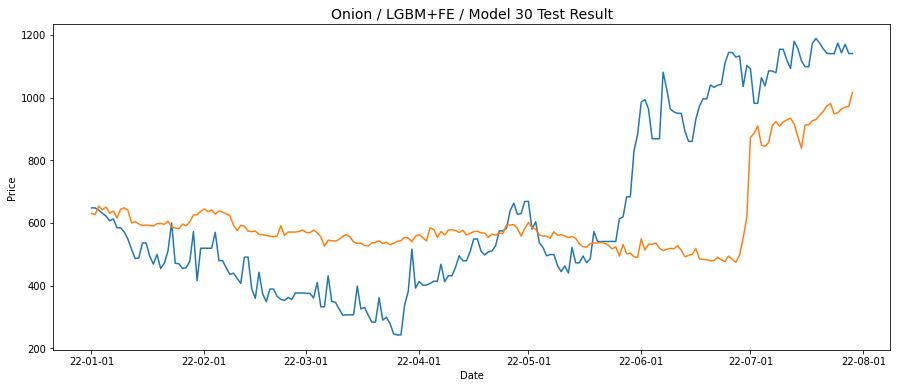

MAPE=31.908983926278133
RMSE=238.77502591976548



Model90 Results



<Figure size 432x288 with 0 Axes>

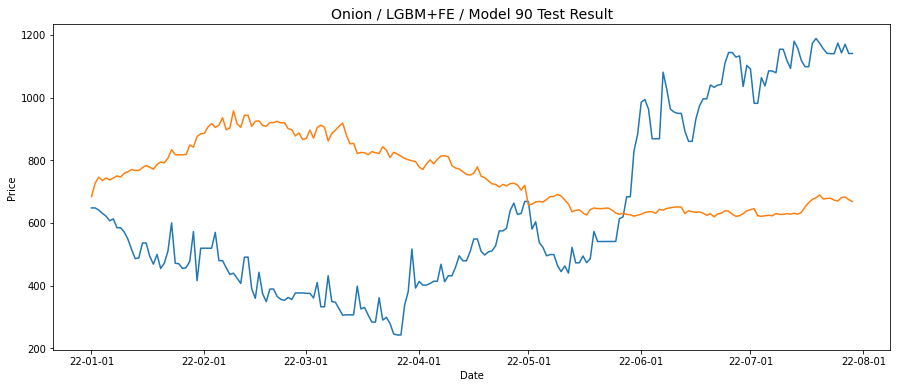

MAPE=69.27860000117013
RMSE=383.67514021791567



Model180 Results



<Figure size 432x288 with 0 Axes>

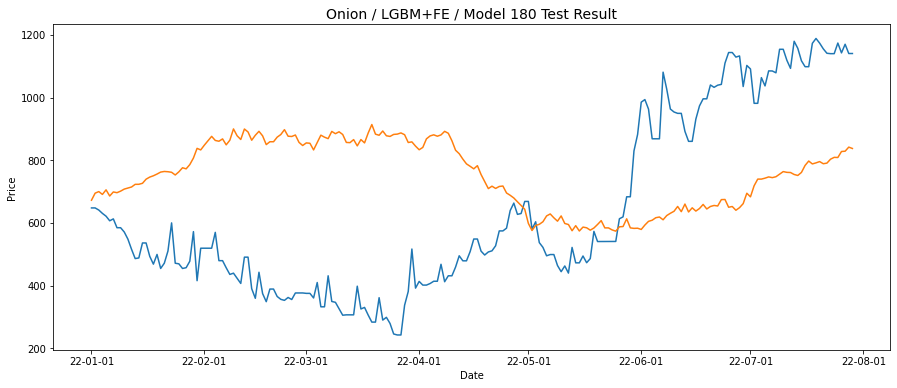

MAPE=65.9540460019748
RMSE=360.7198355099687



Model270 Results



<Figure size 432x288 with 0 Axes>

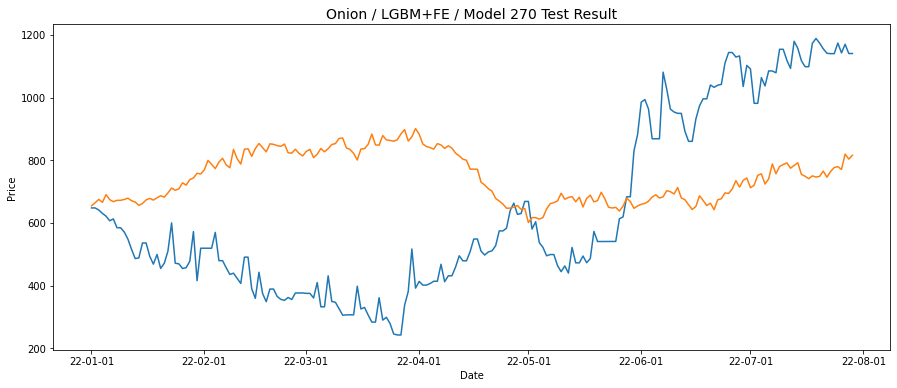

MAPE=62.20291219322347
RMSE=339.1333281591042



Model365 Results



<Figure size 432x288 with 0 Axes>

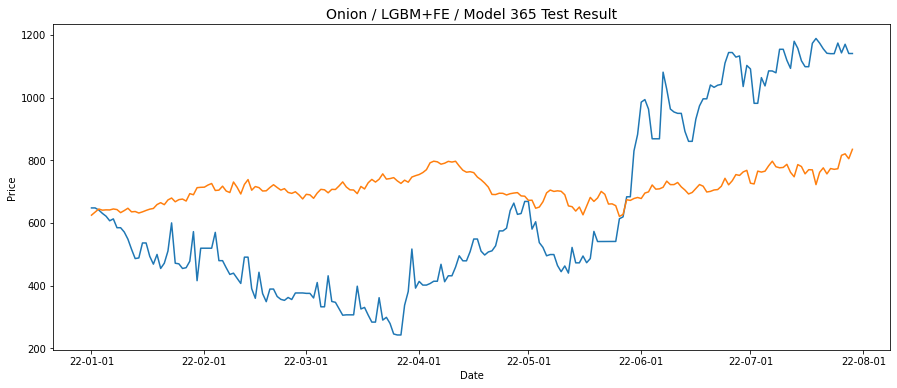

MAPE=50.50039004136888
RMSE=281.8028524964571





<Figure size 432x288 with 0 Axes>

In [12]:
for i in range(0, NSEL):
    
    print(f'Model{SELECTED[i]} Results\n')

    plot_data = pd.DataFrame([y_test.values, pred[i]]).T
    date_label = pd.date_range(start=x_test.index[0], end=x_test.index[-1], freq='D')
    
    fig, ax = plt.subplots(figsize=(15,6))
        
    plot_data.columns = ['actual','pred']
    ax.plot(date_label, plot_data)
    
    plt.title(PDNAME + ' / ' + MDCODE + '+FE / Model ' + str(SELECTED[i]) + ' Test Result', fontsize=14)
    plt.xlabel('Date', fontsize=10)
    plt.ylabel('Price', fontsize=10)
    
    dateFmt = mdates.DateFormatter('%y-%m-%d')
    ax.xaxis.set_major_formatter(dateFmt)
    
    plt.show()
    plt.clf()
    
    MAPE = mean_absolute_percentage_error(y_test.values.flatten(), pred[i])*100
    print(f'MAPE={MAPE}')

    RMSE = np.sqrt(mean_squared_error(y_test.values.flatten(), pred[i]))
    print(f'RMSE={RMSE}\n\n\n')

# LGBM without FE

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

Onion / LGBM / Model30 Training Result



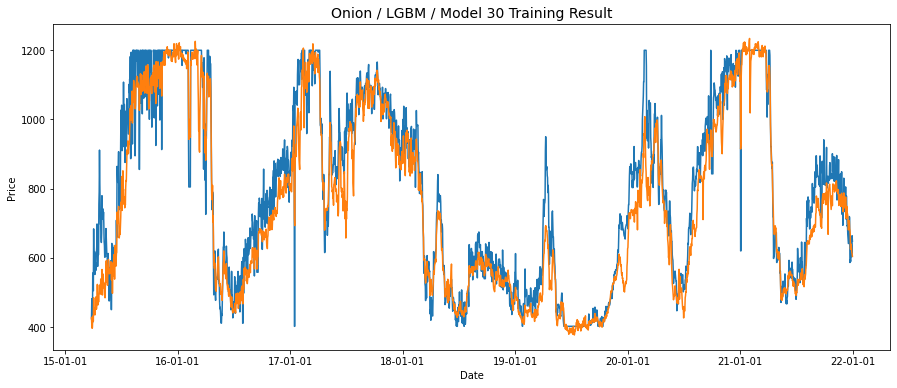

 20%|████████████████▊                                                                   | 1/5 [00:09<00:39,  9.92s/it]

Onion / LGBM / Model90 Training Result



<Figure size 432x288 with 0 Axes>

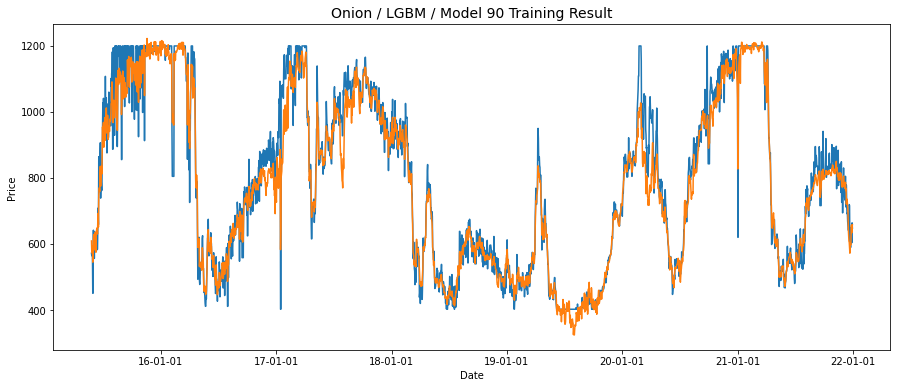

 40%|█████████████████████████████████▌                                                  | 2/5 [00:19<00:29,  9.88s/it]

Onion / LGBM / Model180 Training Result



<Figure size 432x288 with 0 Axes>

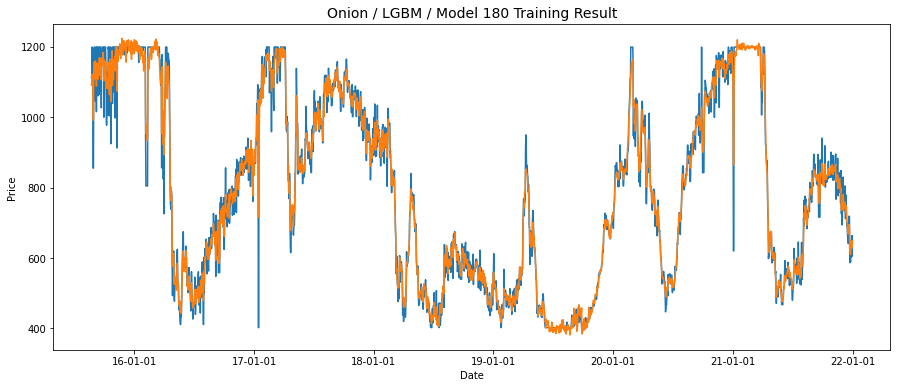

 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:29<00:19,  9.92s/it]

Onion / LGBM / Model270 Training Result



<Figure size 432x288 with 0 Axes>

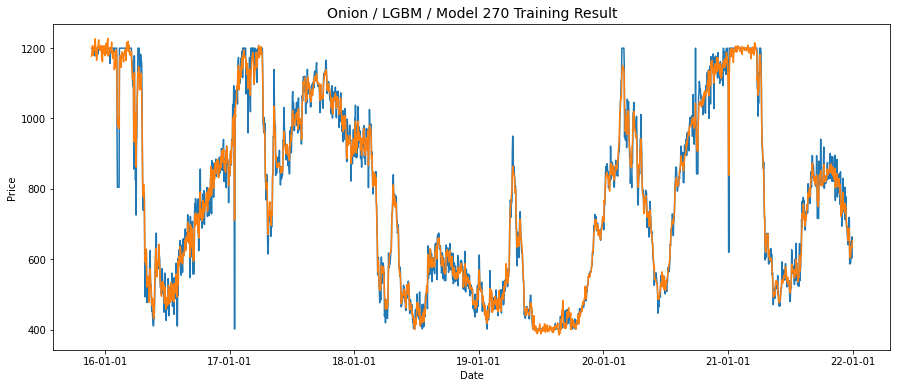

 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:38<00:09,  9.56s/it]

Onion / LGBM / Model365 Training Result



<Figure size 432x288 with 0 Axes>

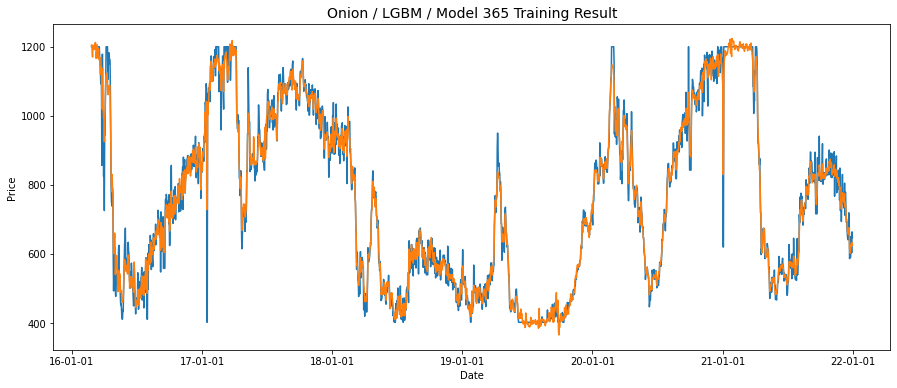

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:47<00:00,  9.54s/it]


<Figure size 432x288 with 0 Axes>

In [13]:
pred=[]

with tf.device("/device:CPU:0"):  

    for day_num in tqdm(SELECTED):
        
        train_all = []
        train_all = raw.iloc[:,:2]

        # Price에 Outlier Treatment 적용 ---------------------#

        winsor_list = []
        winsor_list.append(WINSOR)
        winsor_list.append(100 - WINSOR)

        winsors = np.percentile(train_all['Price'][train_all.index < BASEDATE], winsor_list)
        winsor_min = winsors[0]
        winsor_max = winsors[1]

        train_all['Price'][train_all.index < BASEDATE] = np.where(train_all['Price'][train_all.index < BASEDATE] < winsor_min, winsor_min, train_all['Price'][train_all.index < BASEDATE])
        train_all['Price'][train_all.index < BASEDATE] = np.where(train_all['Price'][train_all.index < BASEDATE] > winsor_max, winsor_max, train_all['Price'][train_all.index < BASEDATE])

        #-----------------------------------------------------#
        
        
        for i in range(day_num, 365 + day_num):
            train_all[f'Price_{i}lag'] = train_all['Price'].shift(i)

        if VARS == 2:  # 거래량을 사용할 경우에만 처리    
            train_all['Volume'] = train_all['Volume'].shift(day_num)
        
        train_all = train_all.dropna(axis=0)  # NaN 결측치가 있는 경우, 학습대상에서 제외
        
        
        train_old = train_all[train_all.index < BASEDATE]
        test_new = train_all[train_all.index >= BASEDATE]   
        
        
        # 검증기간 데이터 FRAC 추가  ---------------------#
        
        train_new = train_old.append(test_new.sample(frac=FRAC))
        
        y_train_raw = train_new['Price']
        x_train_raw = train_new.drop(['Price'],axis=1)        

        #-----------------------------------------------------#
        
        
        # Min-Max Normalization 적용
        scaler_X_tr = preprocessing.MinMaxScaler(feature_range=(0,1))
        X_train = scaler_X_tr.fit_transform(x_train_raw)
        

        # Validation 데이터을 학습에 사용할 경우에 대한 처리        
        
        if SPLIT == 0:
            x_train = X_train
            y_train = y_train_raw
        else:
            x_train = X_train[:-SPLIT]
            y_train = y_train_raw[:-SPLIT]
            x_valid = X_train[-SPLIT:]
            y_valid = y_train_raw[-SPLIT:]
            
            dvalid = lgb.Dataset(x_valid, label=y_valid)

            
        # LGBM Training

        dtrain = lgb.Dataset(x_train, label=y_train)
                
        if SPLIT == 0:
            model = lgb.train(PARAMS, dtrain, num_boost_round=ITER)
        else:
            model = lgb.train(PARAMS, dtrain, num_boost_round=ITER, valid_sets=dvalid, verbose_eval=False)

        # Save model
        joblib.dump(model,f'{PDCODE}_{SMCODE}V{VARS}_{MDCODE}wFE_{day_num}.pkl')   
            

        # 학습한 결과의 예측모델 출력  ---------------------#
        
        y_train_real = train_old['Price']
        x_train_pred = scaler_X_tr.fit_transform(train_old.drop(['Price'],axis=1)) 
        y_train_pred = model.predict(x_train_pred)        
        
        print(f'{PDNAME} / {MDCODE} / Model{day_num} Training Result\n')

        plot_data = pd.concat([pd.DataFrame(y_train_real.values, columns=['actual']), pd.DataFrame(y_train_pred, columns=['pred'])], axis=1)
        date_label = pd.date_range(start=train_old.index[0], end=train_old.index[-1], freq='D')

        fig, ax = plt.subplots(figsize=(15,6))

        ax.plot(date_label, plot_data)

        plt.title(PDNAME + ' / ' + MDCODE + ' / Model ' + str(day_num) + ' Training Result', fontsize=14)
        plt.xlabel('Date', fontsize=10)
        plt.ylabel('Price', fontsize=10)

        dateFmt = mdates.DateFormatter('%y-%m-%d')
        ax.xaxis.set_major_formatter(dateFmt)

        plt.show()
        plt.clf()        
        
        #-----------------------------------------------------#
        
        x_test = test_new.iloc[:,1:]
        y_test = test_new['Price']
        X_test= scaler_X_tr.transform(x_test)
        y_test_pred = model.predict(X_test)
        
        pred.append(y_test_pred)

# LGBM without FE / Visualization

Model30 Results



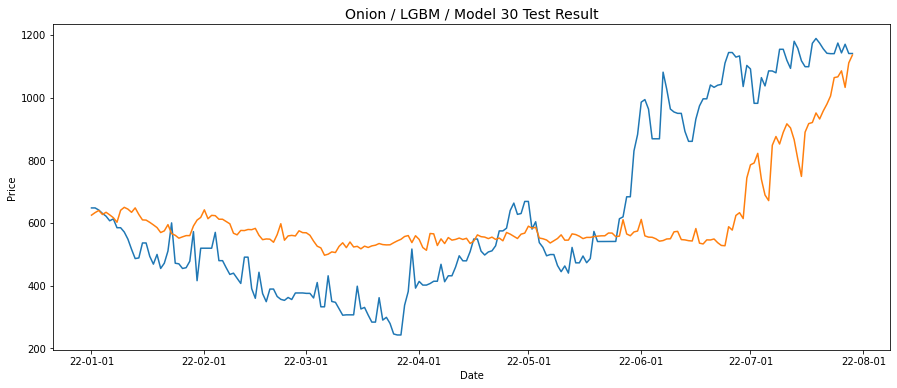

MAPE=29.617910528073786
RMSE=220.51094177851158



Model90 Results



<Figure size 432x288 with 0 Axes>

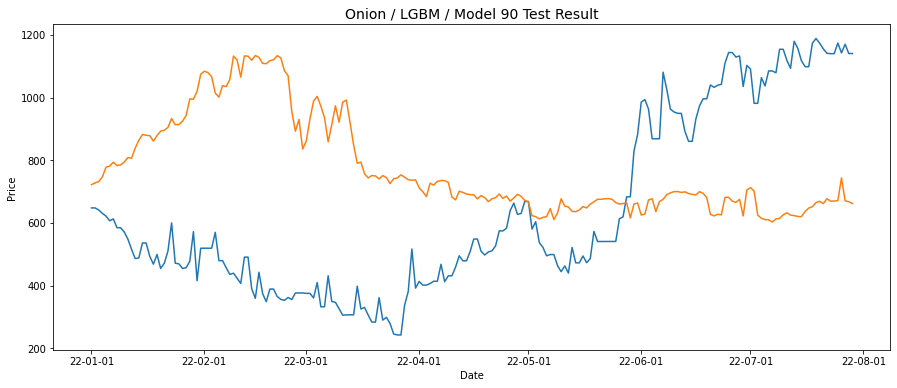

MAPE=73.09910729084379
RMSE=412.70190341013256



Model180 Results



<Figure size 432x288 with 0 Axes>

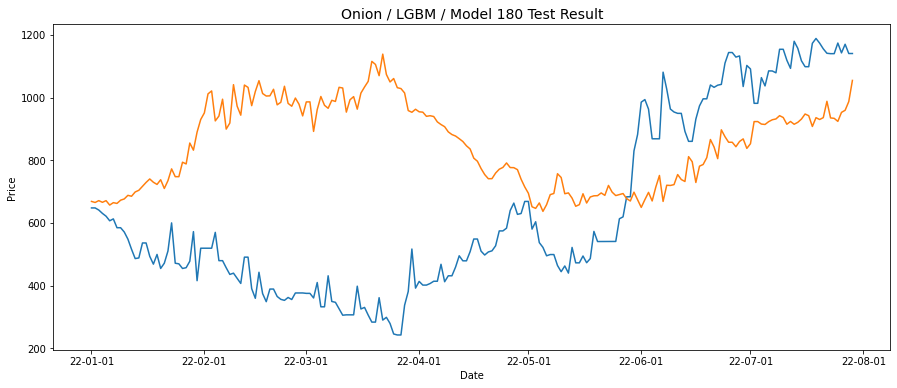

MAPE=75.47887992042088
RMSE=394.8228953137554



Model270 Results



<Figure size 432x288 with 0 Axes>

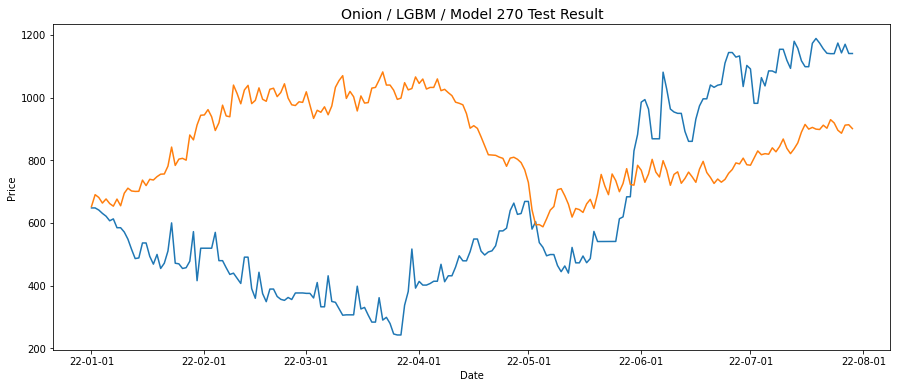

MAPE=78.83358393402861
RMSE=412.85026405013366



Model365 Results



<Figure size 432x288 with 0 Axes>

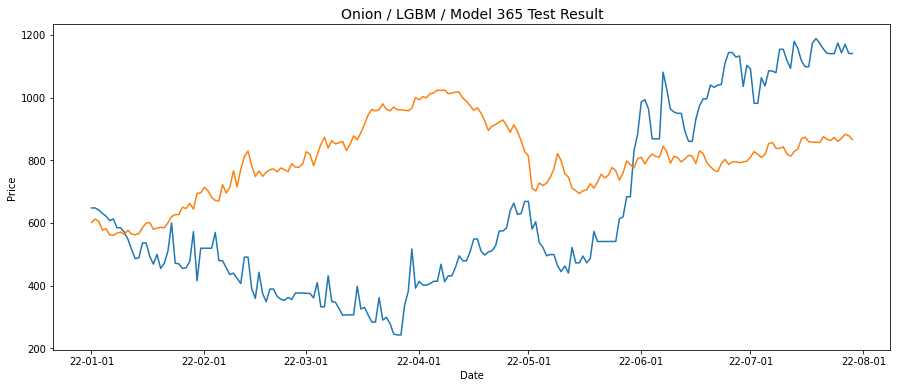

MAPE=65.28965283276726
RMSE=348.73154424655166





<Figure size 432x288 with 0 Axes>

In [14]:
for i in range(0, NSEL):
    
    print(f'Model{SELECTED[i]} Results\n')

    plot_data = pd.DataFrame([y_test.values, pred[i]]).T
    date_label = pd.date_range(start=x_test.index[0], end=x_test.index[-1], freq='D')
    
    fig, ax = plt.subplots(figsize=(15,6))
        
    plot_data.columns = ['actual','pred']
    ax.plot(date_label, plot_data)
    
    plt.title(PDNAME + ' / ' + MDCODE + ' / Model ' + str(SELECTED[i]) + ' Test Result', fontsize=14)
    plt.xlabel('Date', fontsize=10)
    plt.ylabel('Price', fontsize=10)
    
    dateFmt = mdates.DateFormatter('%y-%m-%d')
    ax.xaxis.set_major_formatter(dateFmt)
    
    plt.show()
    plt.clf()
    
    MAPE = mean_absolute_percentage_error(y_test.values.flatten(), pred[i])*100
    print(f'MAPE={MAPE}')

    RMSE = np.sqrt(mean_squared_error(y_test.values.flatten(), pred[i]))
    print(f'RMSE={RMSE}\n\n\n')